# **Modules import**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

# **Utils**

In [2]:
def plot_generated_images(generated_images, nrows, ncols,no_space_between_plots=False, figsize=(10, 10)):
  _, axs = plt.subplots(nrows, ncols,figsize=figsize,squeeze=False)

  for i in range(nrows):
    for j in range(ncols):
      axs[i,j].axis('off')
      generated_images[i][j] = (1 + generated_images[i][j]) / 2
      axs[i,j].imshow(generated_images[i][j])

  if no_space_between_plots:
    plt.subplots_adjust(wspace=0,hspace=0)

  plt.show()

def plot_gan_losses(d_losses,g_losses):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(d_losses)

  line1,=ax1.plot(range(1,epoch_count+1),d_losses,label='discriminator_loss',color='orange')
  ax1.set_ylim([0, max(d_losses)])
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  _=ax1.legend(loc='lower left')

  ax2 = ax1.twinx()
  line2,=ax2.plot(range(1,epoch_count+1),g_losses,label='generator_loss')
  ax2.set_xlim([1,epoch_count])
  ax2.set_ylim([0, max(g_losses)])
  ax2.set_xlabel('Epochs')
  ax2.tick_params(axis='y', labelcolor=line2.get_color())
  _=ax2.legend(loc='upper right')

In [3]:
def chunks(list, n):
    for i in range(0, len(list), n):
        yield list[i:i + n]

def get_random_batch_indices(data_count,batch_size):
    list_indices=list(range(0,data_count))
    random.shuffle(list_indices)
    return list(chunks(list_indices, batch_size))

def get_cgan_real_batch(dataset,batch_indices,label):
  dataset_input=dataset[0]
  dataset_condition_info=dataset[1]
  batch_x =[dataset_input[batch_indices],dataset_condition_info[batch_indices]]
  batch_y=np.full(len(batch_indices),label)

  return batch_x,batch_y

In [4]:
def get_cgan_random_input(batch_size,noise_dim,condition_count):
  noise=np.random.normal(0, 1, size=(batch_size, noise_dim))
  condition_info= to_categorical(np.random.randint(0, condition_count, size=batch_size),condition_count)

  return [noise,condition_info]

def get_cgan_fake_batch(generator,batch_size,generator_input):
  batch_x = [generator.predict(generator_input),generator_input[1]]
  batch_y=np.zeros(batch_size)

  return batch_x,batch_y

In [5]:
def concatenate_cgan_batches(real_batch_x,fake_batch_x):
  batch_input = np.concatenate((real_batch_x[0], fake_batch_x[0]))
  batch_condition_info =np.concatenate((real_batch_x[1], fake_batch_x[1]))

  return [batch_input,batch_condition_info]

In [6]:
def train_gan(gan,generator,discriminator,train_x,train_data_count,input_noise_dim,epoch_count, batch_size,
              get_random_input_func,get_real_batch_func,get_fake_batch_func,concatenate_batches_func,condition_count=-1,
              use_one_sided_labels=False,plt_frq=None,plt_example_count=10,example_shape=(32,32,3)):
    iteration_count = int(train_data_count / batch_size)
    
    print('Epochs: ', epoch_count)
    print('Batch size: ', batch_size)
    print('Iterations: ', iteration_count)
    print('')
    
    #Plot generated images
    if plt_frq!=None:
      print('Before training:')
      noise_to_plot = get_random_input_func(plt_example_count, input_noise_dim,condition_count)
      generated_output = generator.predict(noise_to_plot)
      generated_images = generated_output.reshape(plt_example_count, example_shape[0], example_shape[1], example_shape[2])
      plot_generated_images([generated_images],1,plt_example_count,figsize=(15, 5))
          
    d_epoch_losses=[]
    g_epoch_losses=[]
    for e in range(1, epoch_count+1):
        start_time = time.time()
        avg_d_loss=0
        avg_g_loss=0

        # Training indices are shuffled and grouped into batches
        batch_indices=get_random_batch_indices(train_data_count,batch_size)

        for i in range(iteration_count):
            current_batch_size=len(batch_indices[i])

            # 1. create a batch with real images from the training set
            real_batch_x,real_batch_y=get_real_batch_func(train_x,batch_indices[i],0.9 if use_one_sided_labels else 1)
                        
            # 2. create noise vectors for the generator and generate the images from the noise
            generator_input=get_random_input_func(current_batch_size, input_noise_dim,condition_count)
            fake_batch_x,fake_batch_y=get_fake_batch_func(generator,current_batch_size,generator_input)

            # 3. concatenate real and fake batches into a single batch
            discriminator_batch_x = concatenate_batches_func(real_batch_x, fake_batch_x)
            discriminator_batch_y= np.concatenate((real_batch_y, fake_batch_y))

            # 4. train discriminator
            d_loss = discriminator.train_on_batch(discriminator_batch_x, discriminator_batch_y)
            
            # 5. create noise vectors for the generator
            gan_batch_x = get_random_input_func(current_batch_size, input_noise_dim,condition_count)
            gan_batch_y = np.ones(current_batch_size)    #Flipped labels

            # 6. train generator
            g_loss = gan.train_on_batch(gan_batch_x, gan_batch_y)

            # 7. avg losses
            avg_d_loss+=d_loss*current_batch_size
            avg_g_loss+=g_loss*current_batch_size
            
        avg_d_loss/=train_data_count
        avg_g_loss/=train_data_count

        d_epoch_losses.append(avg_d_loss)
        g_epoch_losses.append(avg_g_loss)

        end_time = time.time()

        print('Epoch: {0} exec_time={1:.1f}s d_loss={2:.3f} g_loss={3:.3f}'.format(e,end_time - start_time,avg_d_loss,avg_g_loss))

        # Update the plots
        if plt_frq!=None and e%plt_frq == 0:
            generated_output = generator.predict(noise_to_plot)
            generated_images = generated_output.reshape(plt_example_count, example_shape[0], example_shape[1], example_shape[2])
            plot_generated_images([generated_images],1,plt_example_count,figsize=(15, 5))
    
    return d_epoch_losses,g_epoch_losses

# **Dataset**

In [7]:
category_count=10 #Number of digit categories

(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

print('Train data flatten shape: ',train_x.shape)
print('Train label shape: ',train_y.shape)
print('Test data flatten shape: ',test_x.shape)
print('Test label shape: ',test_y.shape)

Train data flatten shape:  (50000, 32, 32, 3)
Train label shape:  (50000, 1)
Test data flatten shape:  (10000, 32, 32, 3)
Test label shape:  (10000, 1)


/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


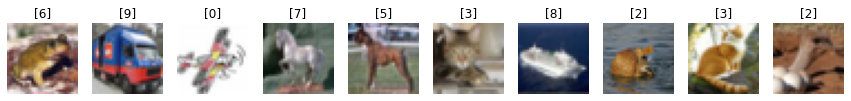

In [8]:
image_count=10

_, axs = plt.subplots(1, image_count,figsize=(15, 10))
for i in range(image_count):
  random_idx=random.randint(0,train_x.shape[0])
  axs[i].imshow(train_x[random_idx],cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(train_y[random_idx])

In [9]:
val_size=10000

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = val_size,random_state = 1,shuffle=True)

print('Train data flatten shape: ',train_x.shape)
print('Train label shape: ',train_y.shape)
print('Validation data flatten shape: ',val_x.shape)
print('Validation label shape: ',val_y.shape)

Train data flatten shape:  (40000, 32, 32, 3)
Train label shape:  (40000, 1)
Validation data flatten shape:  (10000, 32, 32, 3)
Validation label shape:  (10000, 1)


In [10]:
train_x = train_x/255.0
val_x = val_x/255.0
test_x = test_x/255.0

print('Min value: ',train_x.min())
print('Max value: ',train_x.max())

Min value:  0.0
Max value:  1.0


In [11]:
original_image_shape=(train_x.shape[1], train_x.shape[2],  train_x.shape[3])

train_x_flatten=np.reshape(train_x,(train_x.shape[0],-1))
val_x_flatten=np.reshape(val_x,(val_x.shape[0],-1))
test_x_flatten=np.reshape(test_x,(test_x.shape[0],-1))

print('Train data flatten shape: ',train_x_flatten.shape)
print('Validation data flatten shape: ',val_x_flatten.shape)
print('Test data flatten shape: ',test_x_flatten.shape)

Train data flatten shape:  (40000, 3072)
Validation data flatten shape:  (10000, 3072)
Test data flatten shape:  (10000, 3072)


In [12]:
train_y_one_hot = to_categorical(train_y,category_count)
val_y_one_hot=to_categorical(val_y,category_count)
test_y_one_hot=to_categorical(test_y,category_count)

print('Train label one hot encoding shape: ',train_y_one_hot.shape)
print('Validation label one hot encoding shape: ',val_y_one_hot.shape)
print('Test label one hot encoding shape: ',test_y_one_hot.shape)

Train label one hot encoding shape:  (40000, 10)
Validation label one hot encoding shape:  (10000, 10)
Test label one hot encoding shape:  (10000, 10)


In [13]:
train_x_flatten = (train_x_flatten*2)-1
val_x_flatten = (val_x_flatten*2)-1
test_x_flatten = (test_x_flatten*2)-1

generator_output_activation='tanh'
hidden_activation=layers.LeakyReLU(alpha=0.2)

# **CDC-GAN**

In [14]:
use_one_sided_labels=True

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

In [16]:
def build_cdcgan(input_noise_dim,condition_dim):
  input_noise=layers.Input(shape=input_noise_dim, name='input_noise')
  input_condition=layers.Input(shape=condition_dim, name='input_condition')

  input_noise_reshaped=layers.Reshape((1,1,input_noise_dim))(input_noise)
  input_condition_reshaped=layers.Reshape((1,1,condition_dim))(input_condition)

  #Generator
  generator_input = layers.Concatenate(name='generator_input')([input_noise_reshaped, input_condition_reshaped])

  prev_layer=layers.Conv2DTranspose(256,8,strides=1,padding='valid')(generator_input)
  prev_layer=layers.BatchNormalization()(prev_layer)
  prev_layer=layers.LeakyReLU(alpha=0.2)(prev_layer)

  prev_layer=layers.Conv2DTranspose(128,5,strides=2,padding='same')(prev_layer)
  prev_layer=layers.BatchNormalization()(prev_layer)
  prev_layer=layers.LeakyReLU(alpha=0.2)(prev_layer)

  generator_output=layers.Conv2DTranspose(3,5,strides=2,padding='same',activation='tanh',name='generator_output')(prev_layer)

  generator = keras.Model([input_noise,input_condition], generator_output, name='generator')

  #Discriminator
  discriminator_input_sample = layers.Input(shape=(32, 32, 3), name='discriminator_input_sample')
  
  input_condition_dense=layers.Dense(32*32*3)(input_condition)
  discriminator_input_condition=layers.Reshape((32,32,3))(input_condition_dense)
  
  discriminator_input = layers.Concatenate(name='discriminator_input')([discriminator_input_sample, discriminator_input_condition])

  prev_layer=layers.Conv2D(128,5,strides=2,padding='same')(discriminator_input)
  prev_layer=layers.BatchNormalization()(prev_layer)
  prev_layer=layers.LeakyReLU(alpha=0.2)(prev_layer)

  prev_layer=layers.Conv2D(256,5,strides=2,padding='same')(prev_layer)
  prev_layer=layers.BatchNormalization()(prev_layer)
  prev_layer=layers.LeakyReLU(alpha=0.2)(prev_layer)

  prev_layer=layers.Conv2D(1,8,strides=1,padding='valid',activation='sigmoid')(prev_layer)
  discriminator_output=layers.Reshape((1,),name='discriminator_output')(prev_layer)

  discriminator = keras.Model([discriminator_input_sample,input_condition], discriminator_output, name='discriminator')

  #cDCGAN
  cdcgan = keras.Model(generator.input, discriminator([generator.output,input_condition]),name='cdcgan')
  
  return cdcgan,generator,discriminator

In [17]:
input_noise_dim=100

cdcgan,cdcgan_generator,cdcgan_discriminator=build_cdcgan(input_noise_dim,category_count)

2022-05-07 18:09:46.338973: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
cdcgan.summary()

Model: "cdcgan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_noise (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 input_condition (InputLayer)   [(None, 10)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 1, 100)    0           ['input_noise[0][0]']            
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 1, 10)     0           ['input_condition[0][0]']        
                                                                                             

# **Training**

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5)

cdcgan_discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

cdcgan_discriminator.trainable = False
cdcgan.compile(loss='binary_crossentropy', optimizer=optimizer)

Epochs:  100
Batch size:  49
Iterations:  204

Before training:


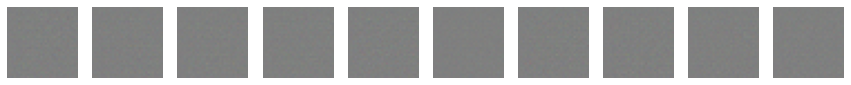

Epoch: 1 exec_time=55.0s d_loss=0.191 g_loss=0.254


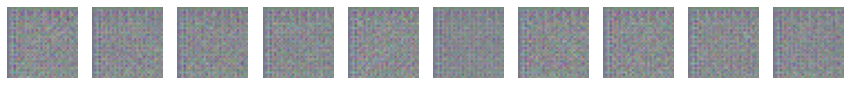

Epoch: 2 exec_time=58.3s d_loss=0.185 g_loss=0.020


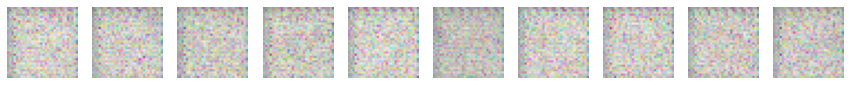

Epoch: 3 exec_time=88.7s d_loss=0.204 g_loss=0.729


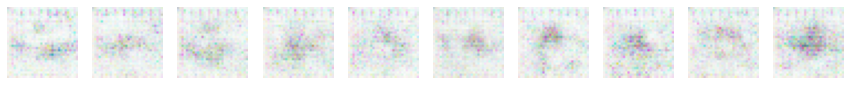

Epoch: 4 exec_time=94.1s d_loss=0.255 g_loss=1.419


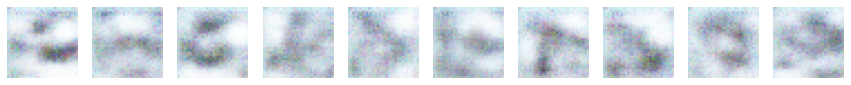

Epoch: 5 exec_time=94.1s d_loss=0.227 g_loss=0.204


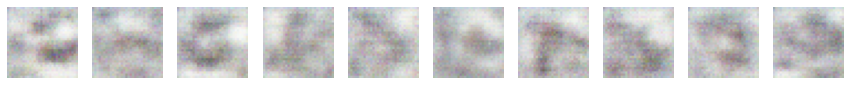

Epoch: 6 exec_time=94.5s d_loss=0.310 g_loss=1.109


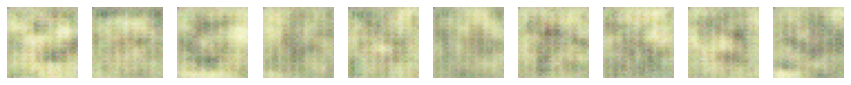

Epoch: 7 exec_time=93.5s d_loss=0.264 g_loss=0.313


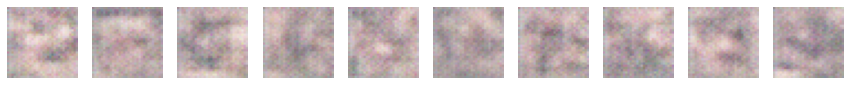

Epoch: 8 exec_time=93.8s d_loss=0.344 g_loss=1.007


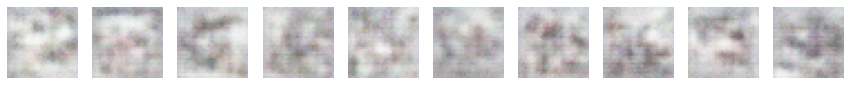

Epoch: 9 exec_time=94.4s d_loss=0.382 g_loss=3.138


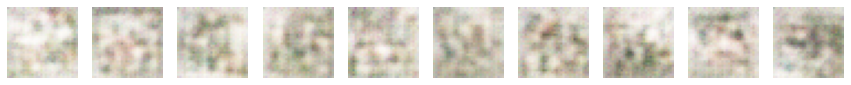

Epoch: 10 exec_time=95.0s d_loss=0.407 g_loss=1.193


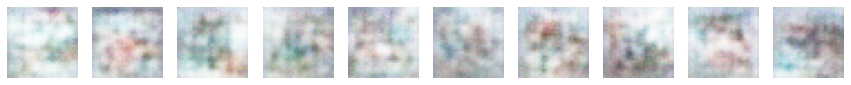

Epoch: 11 exec_time=93.7s d_loss=0.455 g_loss=2.012


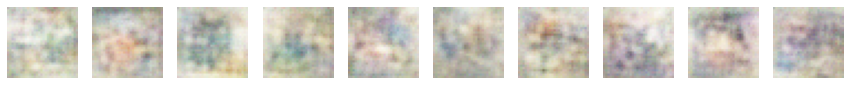

Epoch: 12 exec_time=94.0s d_loss=0.434 g_loss=0.599


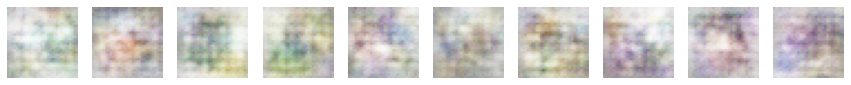

Epoch: 13 exec_time=95.3s d_loss=0.494 g_loss=2.469


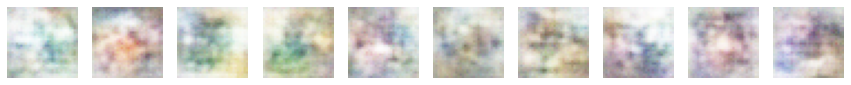

Epoch: 14 exec_time=96.8s d_loss=0.479 g_loss=2.000


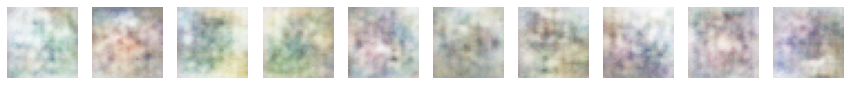

Epoch: 15 exec_time=93.8s d_loss=0.452 g_loss=1.519


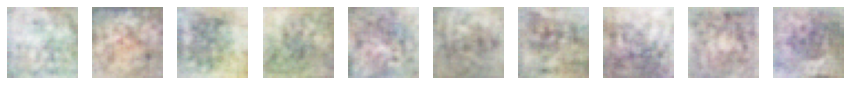

Epoch: 16 exec_time=93.5s d_loss=0.282 g_loss=1.499


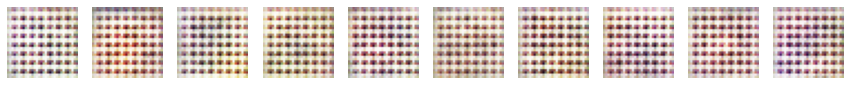

Epoch: 17 exec_time=93.5s d_loss=0.189 g_loss=3.183


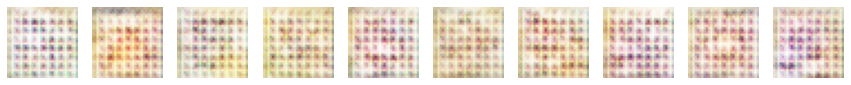

Epoch: 18 exec_time=94.2s d_loss=0.282 g_loss=3.317


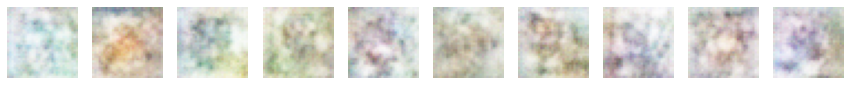

In [20]:
epoch_count=100
batch_size=49

d_epoch_losses,g_epoch_losses=train_gan(cdcgan,
                                        cdcgan_generator,
                                        cdcgan_discriminator,
                                        [val_x,val_y_one_hot],
                                        val_x.shape[0],
                                        input_noise_dim,
                                        epoch_count,
                                        batch_size,
                                        get_cgan_random_input,
                                        get_cgan_real_batch,
                                        get_cgan_fake_batch,
                                        concatenate_cgan_batches,
                                        condition_count=category_count,
                                        use_one_sided_labels=True,
                                        plt_frq=1,
                                        plt_example_count=10)

In [ ]:
plot_gan_losses(d_epoch_losses,g_epoch_losses) 

In [ ]:
cdcgan.save_weights('weights/gan_toy.h5')

# **Generation**

In [ ]:
digit_label=0

noise = np.random.normal(0, 1, size=(1, input_noise_dim))
digit_label_one_hot=to_categorical(digit_label, category_count).reshape(1,-1)

generated_x = cdcgan_generator.predict([noise,digit_label_one_hot])
digit = generated_x[0].reshape(original_image_shape)

plt.axis('off')
plt.imshow(digit, cmap='gray')
plt.show()

In [ ]:
n = 10 # number of images per digit category

generated_images=[]
for digit_label in range(category_count):
  noise = np.random.normal(0, 1, size=(n, input_noise_dim))
  digit_label_one_hot=to_categorical(np.full(n,digit_label), category_count)
  generated_x = cdcgan_generator.predict([noise,digit_label_one_hot])
  generated_images.append([g.reshape(original_image_shape) for g in generated_x])

plot_generated_images(generated_images,category_count,n)